In [122]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Entrenamiento de modelos de prueba
from sklearn.linear_model import LinearRegression

# Evaluación de modelos de prueba
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error

# Partición de train-test set
from sklearn.model_selection import train_test_split

# Crear datasets
from sklearn.datasets import make_regression

Vamos a crear un dataset sintetico utilizando las librerias de [Sklearn Datasets](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_regression.html), en particular nos interesa crear un problema de regresion
lineal al que podemos variarle sus parametros

In [2]:
# Creamos un dataset de prueba
X, y = make_regression(n_samples = 1000,
                       n_features = 1,
                       noise = 2,
                       n_informative = 1,
                       random_state = 42)

new_data = np.append(X,y.reshape(-1,1),axis=1)
new_data.shape

(1000, 2)

In [3]:
df = pd.DataFrame(new_data)

new_col = []
i = 0
for col in df.columns:
    if i ==  len(df.columns) - 1:
        new_col.append("target")
    else :
        new_col.append("feature_" + str(i+1))
        
    i += 1
    
df.columns = new_col

df.head()

,feature_1,target
0,-1.758739,-30.118736
1,1.031845,14.526197
2,-0.487606,-10.119305
3,0.186454,1.700188
4,0.725767,12.345314


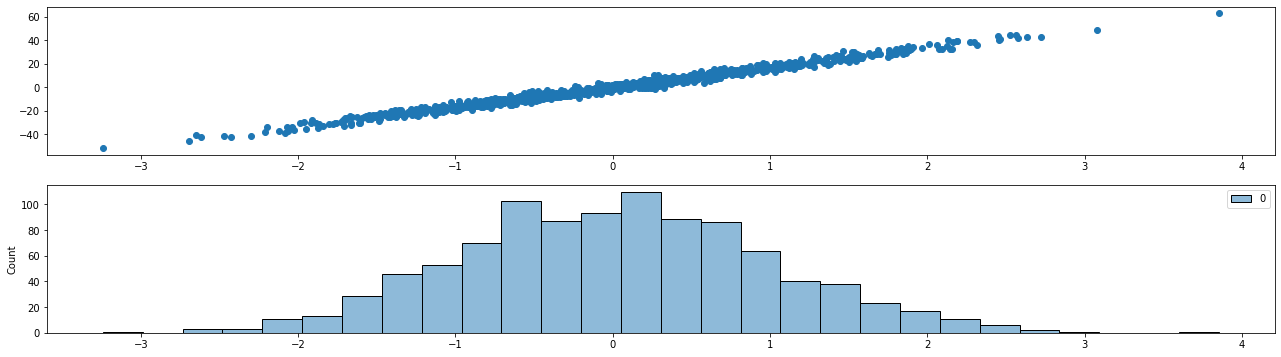

In [4]:
fig,axes = plt.subplots(2,figsize=(22,6))
axes[0].scatter(X,y)
sns.histplot(X, ax=axes[1]);

## Funciones auxiliares para generar datos anómalos

In [5]:
def generate_nulls(df: pd.DataFrame,
                   cols: list = None,
                   percentage: float = 0.05) -> pd.DataFrame:
  """Con esta función vamos a poder generar nulos en ciertas columnas de nuestro
  dataset.
  """  
  cols = df.columns.tolist() if cols is None else cols
  seeds = np.random.randint(100, size = len(cols))
  
  nsamples = np.math.floor(len(df) * percentage)

  result = df.copy(deep = True)
  for i,col_name in enumerate(cols):
      np.random.seed(seeds[i])
      
      idx_to_remove = result[col_name].sample(n = nsamples).index
      result[col_name].iloc[idx_to_remove] = np.nan if result[col_name].dtype in [int,float] else None
  
  return result

def generate_outliers(df: pd.DataFrame,
                     cols: list = None,
                     extreme_outlier: bool = False,
                     percentage: float = 0.02) -> pd.DataFrame:
  """Con esta función vamos a poder generar outliers en ciertas columnas de nuestro
  dataset. Si le damos True a _extreme_outlier_ va a generar outliers con mucho
  peso en la regresión
  """  
  seeds = np.random.randint(100, size = len(df))
  
  nsamples = np.math.floor(len(df) * percentage)
  idx_to_change = df.sample(n = nsamples).index

  cols = df.columns.tolist() if cols is None else cols

  result = df.copy(deep = True)
  
  for i,col_name in enumerate(cols):
    np.random.seed(seeds[i])

    if extreme_outlier:
      iqr = result[col_name].quantile(0.75) - result[col_name].quantile(0.25)
      max_val = 3*iqr
      outlier_sign = [1 if np.random.random() < 0.5 else -1 for _ in range(nsamples)]
      outliers = np.multiply(outlier_sign, np.random.uniform(low = iqr,
                                                          high = max_val,
                                                          size = nsamples))
      
      result[col_name].loc[idx_to_change] = outliers
    else:
      samples = result[col_name].loc[idx_to_change].values
      np.random.shuffle(samples)
      result[col_name].iloc[idx_to_change] = samples
  return result

In [6]:
df_outlier = generate_outliers(df,['target'], percentage = 0.01, extreme_outlier = True)

<AxesSubplot:xlabel='feature_1', ylabel='target'>

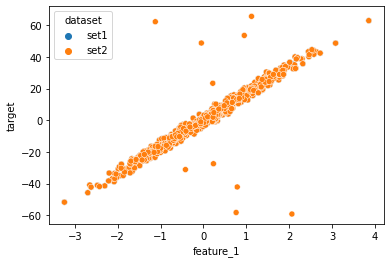

In [7]:
sns.scatterplot(data = pd.concat([df.assign(dataset = 'set1'),
                                 df_outlier.assign(dataset = 'set2')]),
                x = 'feature_1',
                y = 'target',
                hue = 'dataset')

In [8]:
columnas_a_modificar = ['feature_1'] 
df_missing = generate_nulls(df,columnas_a_modificar, percentage = 0.01)

In [9]:
df_missing.isna().sum()

feature_1    10
target        0
dtype: int64

# Primera Parte

## Ejercicio 1

Crear una función que separe los datos en train-validation-test 70-20-10


Hints: 

* Usar Indexing y slicing
* Usar np.random.[...]

In [10]:
def split(df: pd.DataFrame, train_size: float, val_size: float, test_size: float, target_index: int): #suponiendo que nuestro target es solo una columna



    from sklearn.model_selection import train_test_split

    new_col = []
    features = []
    i = 0
    for col in df.columns:
        if i ==  target_index:
            new_col.append("target")
        else :
            new_col.append("feature_" + str(i+1))
            features.append("feature_" + str(i+1))
        i += 1
        
    df.columns = new_col

    X_train, X_test, Y_train, Y_test = train_test_split(df[features],
                                                        df["target"],
                                                        train_size = train_size)
    if val_size > 0:
        X_val, X_test, Y_val, Y_test = train_test_split(X_test,
                                                        Y_test,
                                                        train_size = val_size/(val_size+test_size))

        return X_train, X_val, X_test, Y_train, Y_val, Y_test
    return X_train, X_test, Y_train, Y_test

In [11]:
X_train, X_val, X_test, Y_train, Y_val, Y_test = split(df, 0.7, 0.2, 0.1, 1)

print(len(X_train))
print(len(X_val))
print(len(X_test))

700
200
100


## Ejercicio 2

Utilizando la funcion `generate_nulls`. Insertar en la columna de features un 5% de valores nulos. Con esto, generar una función que les permita rellenar estos valores con la mediana, y otro con la media.

Compare los __scores__ obtenidos en las regresiones cuando tiene el dataset completo, y con los dos métodos de imputación. ¿Cambian mucho?

In [12]:
df.feature_1.median()

0.025300612234888248

In [62]:
df_con_ceros = generate_nulls(df, ["feature_1"], 0.05)
print(df_con_ceros.head(20))
nan_rows = df_con_ceros[df_con_ceros.isna().any(1)]
print(df[df_con_ceros.isna().any(1)]["feature_1"])

    feature_1     target
0   -1.758739 -30.118736
1    1.031845  14.526197
2   -0.487606 -10.119305
3    0.186454   1.700188
4    0.725767  12.345314
5    0.972554  19.787756
6    0.645376   7.333464
7    0.681891  15.203270
8   -1.430141 -22.392221
9    1.066675  15.668652
10   1.550500  28.320533
11  -0.155677  -4.803047
12  -0.269875  -4.685231
13  -2.301921 -41.354186
14  -1.867265 -30.737937
15        NaN  -1.759806
16   0.588317   9.915822
17   1.206509  20.686077
18  -0.192361  -2.826579
19   1.119575  16.538313
15    -0.074433
34     0.232050
79     2.632382
82     0.171368
119    0.781823
122    0.462103
143   -0.919424
180   -0.477657
183    0.881640
191   -0.259591
204   -0.089120
228   -1.026515
261    0.296985
276    0.174578
284   -0.439731
293    0.368673
312   -0.699726
313    1.876171
314   -1.382800
399    0.821903
400   -0.524520
447    0.055725
500   -0.808494
502   -0.342715
523   -0.846794
524    0.196861
530    1.644968
536    2.314659
558    1.305479
568   -0.51

In [65]:
print(df_con_ceros.isna().sum())
print("nueva mediana = {}".format(df_con_ceros.feature_1.median()))

feature_1    50
target        0
dtype: int64
nueva mediana = 0.02275700794585088


In [15]:
df_con_mediana = df_con_ceros.copy(deep=True)
df_con_mediana['feature_1'] = df_con_ceros['feature_1'].replace(np.nan, df_con_ceros.feature_1.median())
print(df_con_mediana.isna().sum())
print("nueva mediana = {}".format(df_con_mediana.feature_1.median()))

feature_1    0
target       0
dtype: int64
nueva mediana = 0.046708570960445436


In [16]:
(df[df_con_ceros.isna().any(1)]["feature_1"] - df_con_mediana[df_con_ceros.isna().any(1)]["feature_1"])/df[df_con_ceros.isna().any(1)]["feature_1"]

16     0.920606
110    1.063903
126    1.022877
130    1.060051
147    0.894758
169    1.047589
180    1.097787
211    0.943684
275    1.116416
290    0.909089
319    0.922924
324    1.052846
346    0.981849
360    1.088169
366    0.945206
376    1.057175
383    0.906207
390    1.165760
406    1.082857
438    0.966703
466    1.074499
492    1.120476
508    0.978408
516    1.017619
529    0.967592
547    0.818643
549    0.929457
603    1.035167
625    1.090295
631    1.089356
637    1.252612
689    0.971387
691    1.056344
709    1.037527
712    1.035379
715    0.938166
774    0.931270
775    1.641347
785    1.041501
795    1.029490
814    1.043187
817    1.038469
834    1.202259
843    0.926318
851    1.080966
856    1.079252
867    1.070490
869    1.033001
878    1.197234
925    1.017829
Name: feature_1, dtype: float64

In [17]:
df_con_media = df_con_ceros.copy(deep=True)
df_con_media['feature_1'] = df_con_ceros['feature_1'].replace(np.nan, df_con_ceros.feature_1.mean())

print(df_con_media.isna().sum())
print("nueva media = {}".format(df_con_media.feature_1.mean()))

feature_1    0
target       0
dtype: int64
nueva media = 0.03400827578458214


In [18]:
(df[df_con_ceros.isna().any(1)]["feature_1"]-df_con_media[df_con_ceros.isna().any(1)]["feature_1"])/df[df_con_ceros.isna().any(1)]["feature_1"]

16     0.942194
110    1.046527
126    1.016657
130    1.043723
147    0.923374
169    1.034649
180    1.071198
211    0.958997
275    1.084762
290    0.933808
319    0.943882
324    1.038477
346    0.986784
360    1.064196
366    0.960104
376    1.041629
383    0.931710
390    1.120689
406    1.060328
438    0.975757
466    1.054243
492    1.087718
508    0.984279
516    1.012829
529    0.976404
547    0.867955
549    0.948638
603    1.025605
625    1.065743
631    1.065060
637    1.183926
689    0.979167
691    1.041023
709    1.027323
712    1.025759
715    0.954979
774    0.949958
775    1.466961
785    1.030216
795    1.021471
814    1.031444
817    1.028009
834    1.147264
843    0.946352
851    1.058951
856    1.057703
867    1.051324
869    1.024028
878    1.143605
925    1.012982
Name: feature_1, dtype: float64

In [19]:
print("mediana original: {} \nmediana rellenando nan con mediana: {} \nmediana rellenando nan con media: {}".format(df.feature_1.median(),df_con_mediana.feature_1.median(),df_con_media.feature_1.median()))
print("\nmedia original: {} \nmedia rellenando nan con mediana: {} \nmedia rellenando nan con media: {}".format(df.feature_1.mean(),df_con_mediana.feature_1.mean(),df_con_media.feature_1.mean()))

mediana original: 0.025300612234888248 
mediana rellenando nan con mediana: 0.046708570960445436 
mediana rellenando nan con media: 0.034008275784582105

media original: 0.01933205582232549 
media rellenando nan con mediana: 0.034643290543375255 
media rellenando nan con media: 0.03400827578458214


Conclusión: para este df rellenar con la media podría ser una mejor aproximación dado que las nuevas media y mediana se encuentran más cerca de las originales en comparación con rellenar los NaN con la mediana

In [20]:
def mean_imputer(df: pd.DataFrame, columns: str) -> pd.DataFrame:
    df_con_media = df.copy(deep=True)
    df_con_media[columns] = df[columns].replace(np.nan, df[columns].mean())
    return df_con_media
    

In [21]:
nuevodf = mean_imputer(df_con_ceros, "feature_1") 
nuevodf

,feature_1,target
0,-1.758739,-30.118736
1,1.031845,14.526197
2,-0.487606,-10.119305
3,0.186454,1.700188
4,0.725767,12.345314
...,...,...
995,-1.918771,-30.210145
996,0.482472,9.182647
997,0.241962,4.855134
998,1.366874,25.785771


In [22]:
def median_imputer(df: pd.DataFrame, columns: str) -> pd.DataFrame:
    df_con_mediana = df.copy(deep=True)
    df_con_mediana[columns] = df[columns].replace(np.nan, df[columns].median())
    return df_con_mediana
    

In [23]:
nuevodf = median_imputer(df_con_ceros, "feature_1") 
nuevodf

,feature_1,target
0,-1.758739,-30.118736
1,1.031845,14.526197
2,-0.487606,-10.119305
3,0.186454,1.700188
4,0.725767,12.345314
...,...,...
995,-1.918771,-30.210145
996,0.482472,9.182647
997,0.241962,4.855134
998,1.366874,25.785771


## Ejercicio 3

Los resultados del ejercicio 2 ¿Cómo se ven afectados cuando empezamos a a tener muchos más valores imputados? Pruebe con distintos porcentajes.

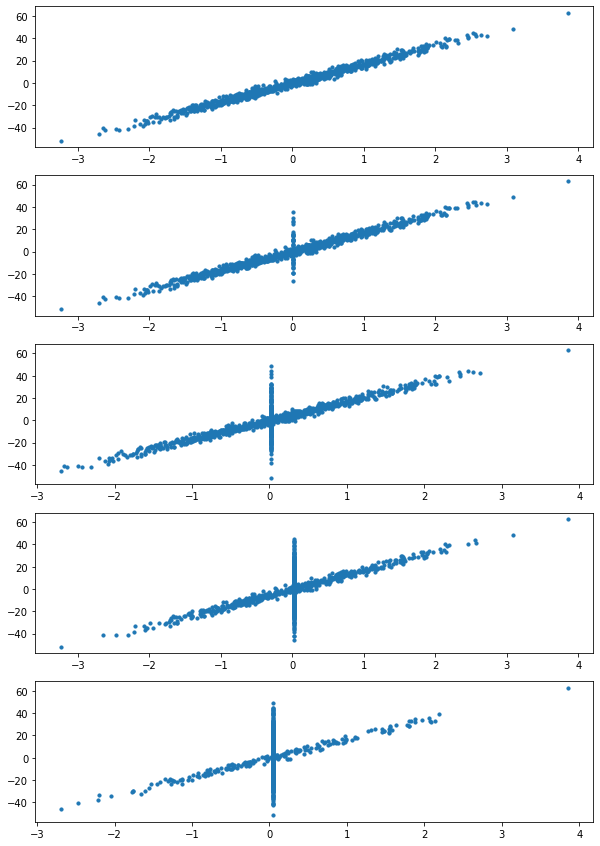

In [53]:
df1 = mean_imputer(generate_nulls(df, ["feature_1"], 0.05),"feature_1")
df2 = mean_imputer(generate_nulls(df, ["feature_1"], 0.20),"feature_1")
df3 = mean_imputer(generate_nulls(df, ["feature_1"], 0.50),"feature_1")
df4 = mean_imputer(generate_nulls(df, ["feature_1"], 0.80),"feature_1")

fig, ax = plt.subplots(5)
fig.set_size_inches(10,15)
ax[0].scatter(df.feature_1,df.target,s=10)
ax[1].scatter(df1.feature_1,df1.target,s=10)
ax[2].scatter(df2.feature_1,df2.target,s=10)
ax[3].scatter(df3.feature_1,df3.target,s=10)
ax[4].scatter(df4.feature_1,df4.target,s=10)

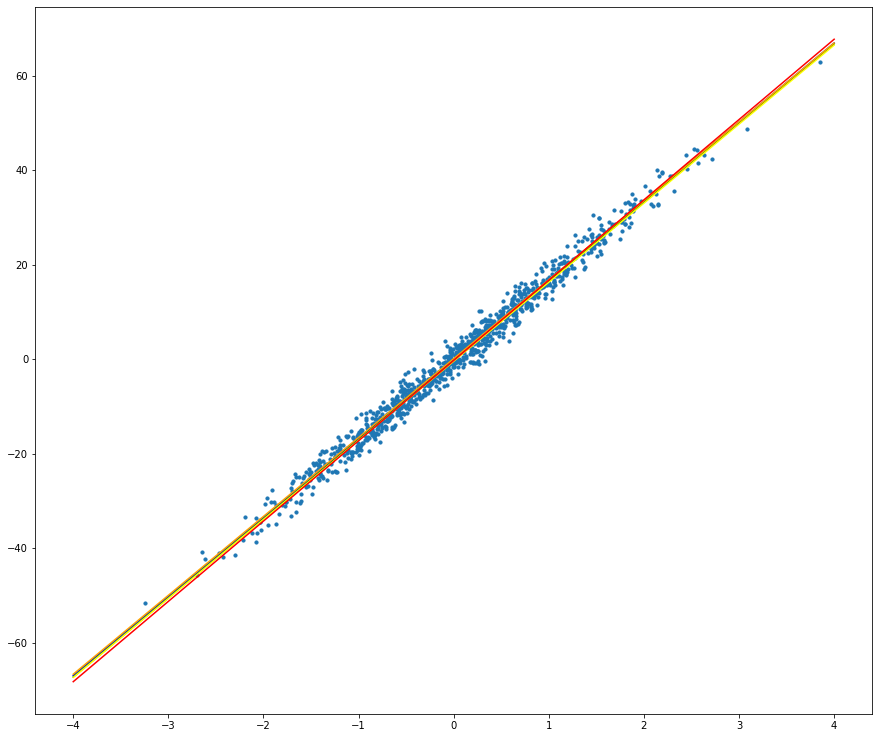

In [39]:
lr = LinearRegression(fit_intercept=True)
lr1 = LinearRegression(fit_intercept=True)
lr2 = LinearRegression(fit_intercept=True)
lr3 = LinearRegression(fit_intercept=True)
lr4 = LinearRegression(fit_intercept=True)

lr.fit(np.array(df.feature_1).reshape(-1,1),np.array(df.target).reshape(-1,1))
lr1.fit(np.array(df1.feature_1).reshape(-1,1),np.array(df1.target).reshape(-1,1))
lr2.fit(np.array(df2.feature_1).reshape(-1,1),np.array(df2.target).reshape(-1,1))
lr3.fit(np.array(df3.feature_1).reshape(-1,1),np.array(df3.target).reshape(-1,1))
lr4.fit(np.array(df4.feature_1).reshape(-1,1),np.array(df4.target).reshape(-1,1))

xspace = np.linspace(-4,4,1000)

yhat=lr.predict(xspace.reshape(1000,1))
yhat_1=lr1.predict(xspace.reshape(1000,1))
yhat_2=lr2.predict(xspace.reshape(1000,1))
yhat_3=lr3.predict(xspace.reshape(1000,1))
yhat_4=lr4.predict(xspace.reshape(1000,1))

f ,ax = plt.subplots(figsize=(15,13))
ax.scatter(df.feature_1,df.target,s=10)
ax.plot(xspace,yhat, color='blue')
ax.plot(xspace,yhat_1, color='green')
ax.plot(xspace,yhat_2, color='yellow')
ax.plot(xspace,yhat_3, color='orange')
ax.plot(xspace,yhat_4, color='red')

In [40]:
print(lr.score(np.array(df.feature_1).reshape(-1,1),np.array(df.target).reshape(-1,1)))
print(lr1.score(np.array(df1.feature_1).reshape(-1,1),np.array(df1.target).reshape(-1,1)))
print(lr2.score(np.array(df2.feature_1).reshape(-1,1),np.array(df2.target).reshape(-1,1)))
print(lr3.score(np.array(df3.feature_1).reshape(-1,1),np.array(df3.target).reshape(-1,1)))
print(lr2.score(np.array(df4.feature_1).reshape(-1,1),np.array(df4.target).reshape(-1,1)))

0.9855792900364626
0.9229567276345211
0.7763356115134086
0.493466537558513
0.1933031557331939


Se probaron con diferentes porcentajes de valores imputados (5, 20, 50 y 80%) y si bien existen diferencias entre las rectas de regresión para cada dataframe (alejándose cada vez más de la regresión hecha con el dataframe original), gráficamente no son muy significativas. Sin embargo se ve una caída notable en el score de estas regresiones al aumentar la cantidad de valores imputados.

## Ejercicio 4

Utilizando la funcion `generate_outliers` generar puntos extremos dentro de los datos que generamos anteriormente. En este ejercicio dejar setteado `extreme_outliers` como `False` y observe como variando el porcentaje de los mismos la regresión comienza a afectarse.

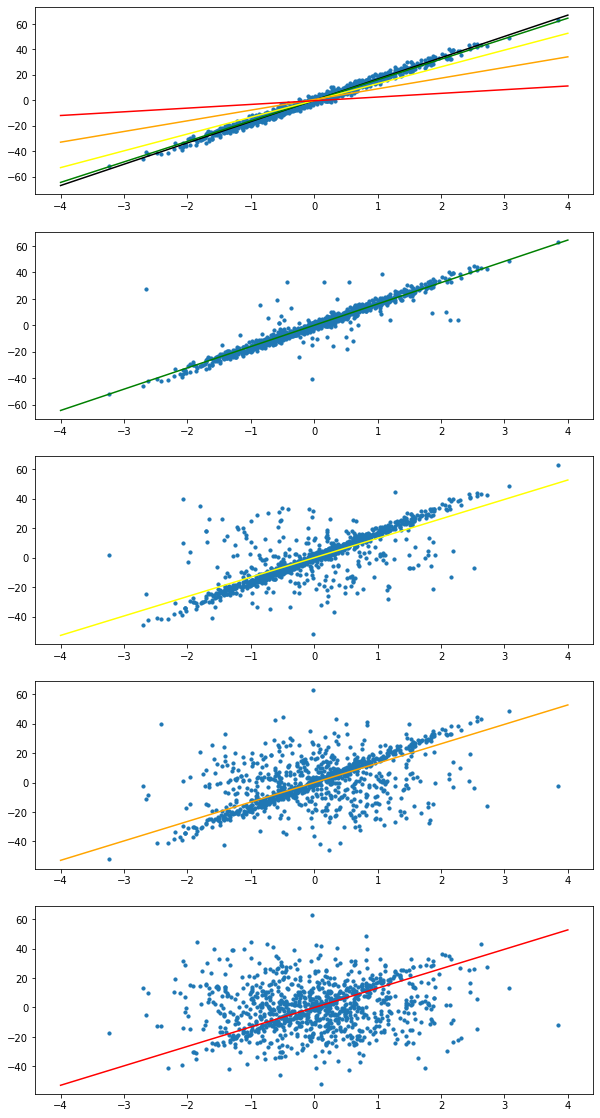

Score de la regresión sin outliers: 0.9855768436954228
Score de la regresión con un 5% de outliers: 0.9105237195114876
Score de la regresión con un 25% de outliers: 0.5719756569862675
Score de la regresión con un 50% de outliers: 0.26734903484134165
Score de la regresión con un 80% de outliers: 0.025805792841832376


In [88]:
df_o1 = generate_outliers(df,['target'], percentage = 0.05, extreme_outlier = False)
df_o2 = generate_outliers(df,['target'], percentage = 0.25, extreme_outlier = False)
df_o3 = generate_outliers(df,['target'], percentage = 0.50, extreme_outlier = False)
df_o4 = generate_outliers(df,['target'], percentage = 0.80, extreme_outlier = False)

X_train, X_val, X_test, Y_train, Y_val, Y_test = split(df, 0.7, 0.2, 0.1, 1)
X_train_o1, X_val_o1, X_test_o1, Y_train_o1, Y_val_o1, Y_test_o1 = split(df_o1, 0.7, 0.2, 0.1, 1)
X_train_o2, X_val_o2, X_test_o2, Y_train_o2, Y_val_o2, Y_test_o2 = split(df_o2, 0.7, 0.2, 0.1, 1)
X_train_o3, X_val_o3, X_test_o3, Y_train_o3, Y_val_o3, Y_test_o3 = split(df_o3, 0.7, 0.2, 0.1, 1)
X_train_o4, X_val_o4, X_test_o4, Y_train_o4, Y_val_o4, Y_test_o4 = split(df_o4, 0.7, 0.2, 0.1, 1)

lr = LinearRegression(fit_intercept=True)
lr.fit(np.array(X_train.feature_1).reshape(-1,1),Y_train)
lr_o1 = LinearRegression(fit_intercept=True)
lr_o1.fit(np.array(X_train_o1.feature_1).reshape(-1,1),Y_train_o1)
lr_o2 = LinearRegression(fit_intercept=True)
lr_o2.fit(np.array(X_train_o2.feature_1).reshape(-1,1),Y_train_o2)
lr_o3 = LinearRegression(fit_intercept=True)
lr_o3.fit(np.array(X_train_o3.feature_1).reshape(-1,1),Y_train_o3)
lr_o4 = LinearRegression(fit_intercept=True)
lr_o4.fit(np.array(X_train_o4.feature_1).reshape(-1,1),Y_train_o4)

xspace = np.linspace(-4,4,1000)
yhat=lr.predict(xspace.reshape(1000,1))
yhat_o1=lr_o1.predict(xspace.reshape(1000,1))
yhat_o2=lr_o2.predict(xspace.reshape(1000,1))
yhat_o3=lr_o3.predict(xspace.reshape(1000,1))
yhat_o4=lr_o4.predict(xspace.reshape(1000,1))

fig, ax = plt.subplots(5)
fig.set_size_inches(10,20)

ax[0].scatter(df.feature_1,df.target,s=10)
ax[0].plot(xspace,yhat, color='black')
ax[0].plot(xspace,yhat_o1, color='green')
ax[0].plot(xspace,yhat_o2, color='yellow')
ax[0].plot(xspace,yhat_o3, color='orange')
ax[0].plot(xspace,yhat_o4, color='red')
ax[1].scatter(df_o1.feature_1,df_o1.target,s=10)
ax[1].plot(xspace,yhat_o1, color='green')
ax[2].scatter(df_o2.feature_1,df_o2.target,s=10)
ax[2].plot(xspace,yhat_o2, color='yellow')
ax[3].scatter(df_o3.feature_1,df_o3.target,s=10)
ax[3].plot(xspace,yhat_o2, color='orange')
ax[4].scatter(df_o4.feature_1,df_o4.target,s=10)
ax[4].plot(xspace,yhat_o2, color='red')


plt.show()
print(f"Score de la regresión sin outliers: {lr.score(np.array(df.feature_1).reshape(-1,1),np.array(df.target).reshape(-1,1))}")
print(f"Score de la regresión con un 5% de outliers: {lr_o1.score(np.array(df_o1.feature_1).reshape(-1,1),np.array(df_o1.target).reshape(-1,1))}")
print(f"Score de la regresión con un 25% de outliers: {lr_o2.score(np.array(df_o2.feature_1).reshape(-1,1),np.array(df_o2.target).reshape(-1,1))}")
print(f"Score de la regresión con un 50% de outliers: {lr_o3.score(np.array(df_o3.feature_1).reshape(-1,1),np.array(df_o3.target).reshape(-1,1))}")
print(f"Score de la regresión con un 80% de outliers: {lr_o4.score(np.array(df_o4.feature_1).reshape(-1,1),np.array(df_o4.target).reshape(-1,1))}")


## Ejercicio 5

Generar ahora valores extremos utilizando `extreme_outliers`. ¿Cómo afecta esto a la regresión? ¿Se observa algo interesante?


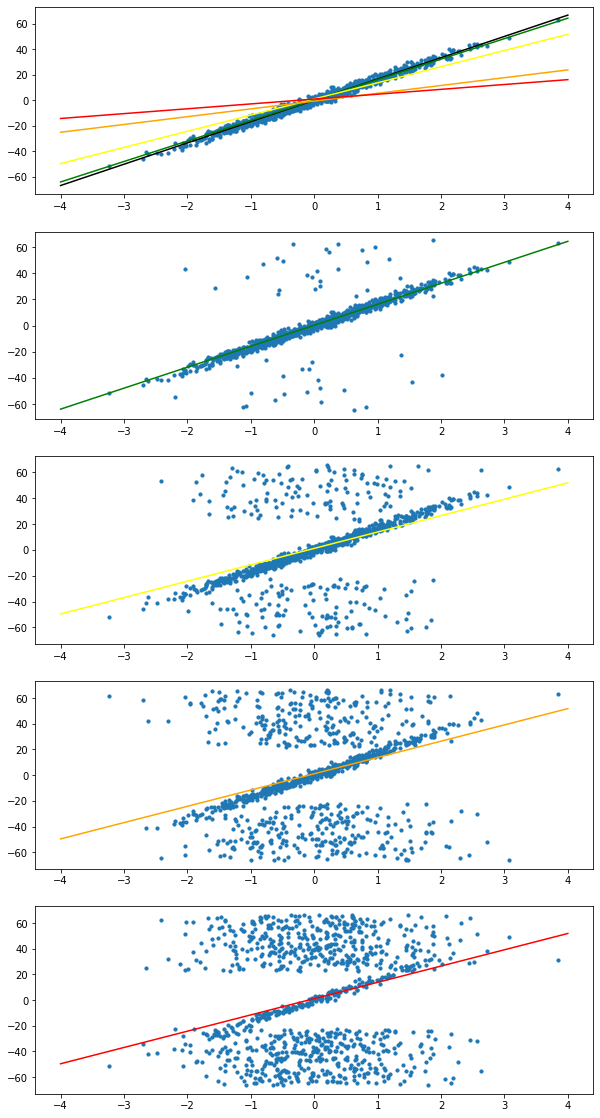

Score de la regresión sin outliers: 0.9855744062720088
Score de la regresión con un 5% de outliers pesados: 0.7000043867874834
Score de la regresión con un 25% de outliers pesados: 0.22561720874978042
Score de la regresión con un 50% de outliers pesados: 0.031064227264652966
Score de la regresión con un 80% de outlier spesados: 0.009176695616453623


In [87]:
df_eo1 = generate_outliers(df,['target'], percentage = 0.05, extreme_outlier = True)
df_eo2 = generate_outliers(df,['target'], percentage = 0.25, extreme_outlier = True)
df_eo3 = generate_outliers(df,['target'], percentage = 0.50, extreme_outlier = True)
df_eo4 = generate_outliers(df,['target'], percentage = 0.80, extreme_outlier = True)

X_train, X_val, X_test, Y_train, Y_val, Y_test = split(df, 0.7, 0.2, 0.1, 1)
X_train_eo1, X_val_eo1, X_test_eo1, Y_train_eo1, Y_val_eo1, Y_test_eo1 = split(df_eo1, 0.7, 0.2, 0.1, 1)
X_train_eo2, X_val_eo2, X_test_eo2, Y_train_eo2, Y_val_eo2, Y_test_eo2 = split(df_eo2, 0.7, 0.2, 0.1, 1)
X_train_eo3, X_val_eo3, X_test_eo3, Y_train_eo3, Y_val_eo3, Y_test_eo3 = split(df_eo3, 0.7, 0.2, 0.1, 1)
X_train_eo4, X_val_eo4, X_test_eo4, Y_train_eo4, Y_val_eo4, Y_test_eo4 = split(df_eo4, 0.7, 0.2, 0.1, 1)

lr = LinearRegression(fit_intercept=True)
lr.fit(np.array(X_train.feature_1).reshape(-1,1),Y_train)
lr_eo1 = LinearRegression(fit_intercept=True)
lr_eo1.fit(np.array(X_train_eo1.feature_1).reshape(-1,1),Y_train_eo1)
lr_eo2 = LinearRegression(fit_intercept=True)
lr_eo2.fit(np.array(X_train_eo2.feature_1).reshape(-1,1),Y_train_eo2)
lr_eo3 = LinearRegression(fit_intercept=True)
lr_eo3.fit(np.array(X_train_eo3.feature_1).reshape(-1,1),Y_train_eo3)
lr_eo4 = LinearRegression(fit_intercept=True)
lr_eo4.fit(np.array(X_train_eo4.feature_1).reshape(-1,1),Y_train_eo4)

xspace = np.linspace(-4,4,1000)
yhat=lr.predict(xspace.reshape(1000,1))
yhat_eo1=lr_eo1.predict(xspace.reshape(1000,1))
yhat_eo2=lr_eo2.predict(xspace.reshape(1000,1))
yhat_eo3=lr_eo3.predict(xspace.reshape(1000,1))
yhat_eo4=lr_eo4.predict(xspace.reshape(1000,1))

fig, ax = plt.subplots(5)
fig.set_size_inches(10,20)

ax[0].scatter(df.feature_1,df.target,s=10)
ax[0].plot(xspace,yhat, color='black')
ax[0].plot(xspace,yhat_eo1, color='green')
ax[0].plot(xspace,yhat_eo2, color='yellow')
ax[0].plot(xspace,yhat_eo3, color='orange')
ax[0].plot(xspace,yhat_eo4, color='red')
ax[1].scatter(df_eo1.feature_1,df_eo1.target,s=10)
ax[1].plot(xspace,yhat_eo1, color='green')
ax[2].scatter(df_eo2.feature_1,df_eo2.target,s=10)
ax[2].plot(xspace,yhat_eo2, color='yellow')
ax[3].scatter(df_eo3.feature_1,df_eo3.target,s=10)
ax[3].plot(xspace,yhat_eo2, color='orange')
ax[4].scatter(df_eo4.feature_1,df_eo4.target,s=10)
ax[4].plot(xspace,yhat_eo2, color='red')

plt.show()
print(f"Score de la regresión sin outliers: {lr.score(np.array(df.feature_1).reshape(-1,1),np.array(df.target).reshape(-1,1))}")
print(f"Score de la regresión con un 5% de outliers pesados: {lr_eo1.score(np.array(df_eo1.feature_1).reshape(-1,1),np.array(df_eo1.target).reshape(-1,1))}")
print(f"Score de la regresión con un 25% de outliers pesados: {lr_eo2.score(np.array(df_eo2.feature_1).reshape(-1,1),np.array(df_eo2.target).reshape(-1,1))}")
print(f"Score de la regresión con un 50% de outliers pesados: {lr_eo3.score(np.array(df_eo3.feature_1).reshape(-1,1),np.array(df_eo3.target).reshape(-1,1))}")
print(f"Score de la regresión con un 80% de outliers pesados: {lr_eo4.score(np.array(df_eo4.feature_1).reshape(-1,1),np.array(df_eo4.target).reshape(-1,1))}")

Al agregar outliers extremos la Regresión y su score se ven afectados de mayor manera (mucho más que con outliers no extremos) según el porcentaje de outliers que se agreguen.

## Ejercicio 6

utilizando el archivo CSV `clase3v2.csv`, vamos a cargarlo como dataframe y deberemos:
 - Generar splits de training/test
 - Limpiar/Imputar datos Nulos
 - Entrenar un modelo de regresión multivariada
 - Reportar $R^2$ en test.

In [66]:
data_happiness = pd.read_csv('clase3v2.csv', delimiter = ';')

In [67]:
data_happiness.isna().sum()

feature_1        0
feature_2        0
feature_3       25
feature_4        0
feature_5       15
feature_6        0
target_value     0
dtype: int64

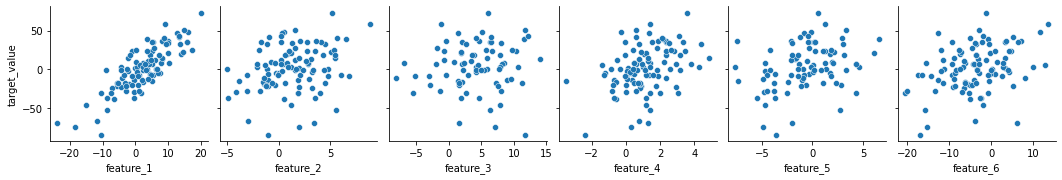

In [68]:
sns.pairplot(data_happiness,x_vars=["feature_1","feature_2","feature_3","feature_4","feature_5","feature_6"],y_vars='target_value')
plt.show()

In [69]:
nan_rows = data_happiness[data_happiness.isna().any(1)]
nan_rows

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,target_value
0,3.669506,2.863605,NaN,2.948632,NaN,-9.364512,7.564543
1,13.505001,4.482330,NaN,0.770769,NaN,-3.706287,32.866898
2,-5.736774,-1.030994,NaN,0.907981,NaN,5.332656,-20.922094
3,-0.019325,1.909841,NaN,0.137427,NaN,3.400036,1.433380
4,6.079670,1.528345,NaN,0.746475,NaN,-11.486688,11.867943
5,-6.563463,0.476897,NaN,-0.576820,NaN,-5.003375,-37.913852
6,-7.113890,3.163686,NaN,0.832526,NaN,-6.500592,-23.741118
7,-0.460477,1.811576,NaN,-0.687152,NaN,-12.717867,-14.039603
8,-4.434366,1.919696,NaN,2.913292,NaN,-9.078455,-23.122893
9,-7.419374,4.003187,NaN,1.961815,NaN,-5.161921,-30.392307


In [70]:
X_train, X_test, Y_train, Y_test = split(data_happiness, 0.8, 0, 0.2, 6)

In [71]:
df_train = pd.concat([X_train, Y_train], axis=1)
df_train

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,target
35,4.031313,-2.081522,8.138464,0.589899,4.300039,-4.069205,7.588145
75,3.711264,2.883610,9.639910,0.072790,-4.931949,-8.884144,-11.652328
19,13.779227,0.797328,NaN,1.050136,1.730029,-7.487210,20.165501
14,-11.799676,-2.961813,NaN,0.779812,NaN,-3.846574,-66.928472
98,7.060369,4.293074,3.590226,-0.066123,-2.039099,-3.643987,18.831133
...,...,...,...,...,...,...,...
15,4.375432,-0.119966,NaN,0.043858,-0.347020,0.880032,-6.119577
0,3.669506,2.863605,NaN,2.948632,NaN,-9.364512,7.564543
57,0.359445,3.218704,4.231046,0.244294,0.017648,4.255268,-3.373316
9,-7.419374,4.003187,NaN,1.961815,NaN,-5.161921,-30.392307


Elimino las filas donde tengo más de un NaN

In [72]:
df_train = df_train.dropna(thresh=6)
nan_rows = df_train[df_train.isna().any(1)]
nan_rows

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,target
19,13.779227,0.797328,NaN,1.050136,1.730029,-7.487210,20.165501
16,3.677814,-5.059008,NaN,-0.339200,-0.905344,0.267167,-0.027864
24,5.299924,4.069708,NaN,2.339350,-0.341389,3.438438,35.166792
17,0.980800,6.037507,NaN,1.356027,-0.871009,-9.340529,-7.221765
22,0.598013,-1.030075,NaN,0.490533,-3.662214,-0.366133,-5.778775
21,-2.381354,0.275137,NaN,0.040952,-4.664043,-11.818938,-2.417554
23,-0.491433,-4.209465,NaN,0.024498,-4.825984,-7.016355,-28.965822
18,5.413667,2.046161,NaN,1.192531,-0.831636,-17.361673,-7.286225
20,6.959910,-0.023091,NaN,0.276465,1.729196,-8.667381,-4.605250
15,4.375432,-0.119966,NaN,0.043858,-0.347020,0.880032,-6.119577


In [73]:
X_train = pd.concat([df_train.feature_1, df_train.feature_2, df_train.feature_3, df_train.feature_4, df_train.feature_5, df_train.feature_6], axis=1)
Y_train = df_train.target

Las filas con un NaN reemplazo por la media de ese feature

In [74]:
X_train = mean_imputer(X_train, "feature_3")
X_train.isna().sum()

feature_1    0
feature_2    0
feature_3    0
feature_4    0
feature_5    0
feature_6    0
dtype: int64

In [75]:
lr = LinearRegression(fit_intercept=True)
lr.fit(X_train,Y_train)
lr.coef_, lr.score(X_train,Y_train), lr.intercept_

(array([ 3.05755026,  1.32164539,  0.32502674,  5.61908352, -0.08408363,
         1.20489546]),
 0.9200877297333651,
 -9.743663228042596)

In [76]:
df_test = pd.concat([X_test, Y_test], axis=1)
df_test = df_test.dropna()
X_test = pd.concat([df_test.feature_1, df_test.feature_2, df_test.feature_3, df_test.feature_4, df_test.feature_5, df_test.feature_6], axis=1)
Y_test = df_test.target 

In [78]:
lr.score(X_test, Y_test)

0.8451228732879387

\begin{equation}

    \begin{array}{rcl}
        \text{Target} &=& -10.576 +
                                3.016 \cdot \text{feature1} +
                                1.309 \cdot \text{feature2} -
                                0.327 \cdot \text{feature3} +
                                5.209 \cdot \text{feature4} - \\
                            & & 0.412 \cdot \text{feature5} +
                                1.027 \cdot \text{feature6} 
                                
    \end{array}
\end{equation}

## Ejercicio 7

Por último, manteniendo un dataset limpio como el que generamos previo al ejercio 1, utilizando `make_regression` de `scikit-learn`. Analizar que pasa si comenzamos a modificar el parametro `noise`

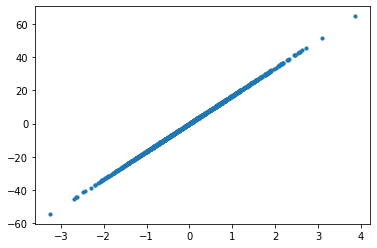

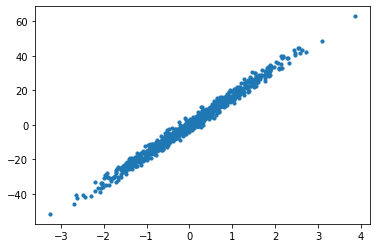

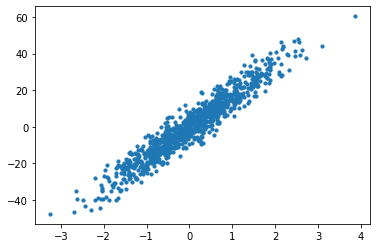

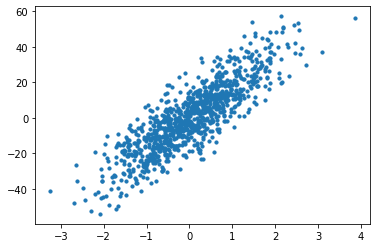

In [80]:
# Creamos un dataset de prueba
X0, y0 = make_regression(n_samples = 1000,
                       n_features = 1,
                       noise = 0,
                       n_informative = 1,
                       random_state = 42)

X2, y2 = make_regression(n_samples = 1000,
                       n_features = 1,
                       noise = 2,
                       n_informative = 1,
                       random_state = 42)

X5, y5 = make_regression(n_samples = 1000,
                       n_features = 1,
                       noise = 5,
                       n_informative = 1,
                       random_state = 42)

X10, y10 = make_regression(n_samples = 1000,
                       n_features = 1,
                       noise = 10,
                       n_informative = 1,
                       random_state = 42)
dfs = [pd.DataFrame(np.append(X0,y0.reshape(-1,1),axis=1)),
        pd.DataFrame(np.append(X2,y2.reshape(-1,1),axis=1)),
        pd.DataFrame(np.append(X5,y5.reshape(-1,1),axis=1)),
        pd.DataFrame(np.append(X10,y10.reshape(-1,1),axis=1))]

for df in dfs:

    new_col = []
    i = 0
    for col in df.columns:
        if i ==  len(df.columns) - 1:
            new_col.append("target")
        else :
            new_col.append("feature_" + str(i+1))
            
        i += 1
        
    df.columns = new_col
    f ,ax = plt.subplots()
    ax.scatter(df.feature_1,df.target,s=10)



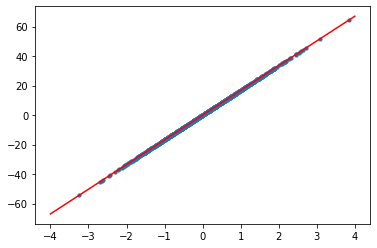

b0 = [[16.74825823]] ; score = 1.0


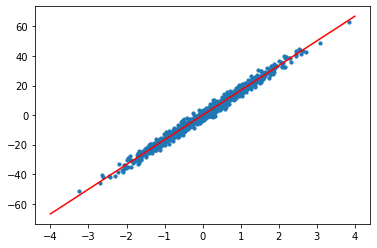

b0 = [[16.72531579]] ; score = 0.9855792900364626


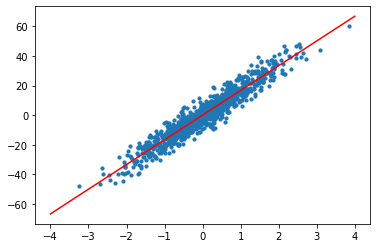

b0 = [[16.69090214]] ; score = 0.9158971293727719


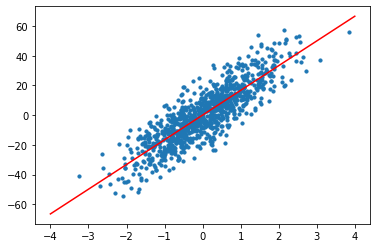

b0 = [[16.63354605]] ; score = 0.7300121896115735


In [81]:

for df in dfs:
    lr =LinearRegression(fit_intercept=True)
    lr.fit(np.array(df.feature_1).reshape(-1,1),np.array(df.target).reshape(-1,1))
    f ,ax = plt.subplots()
    ax.scatter(df.feature_1,df.target,s=10)
    ax.plot(np.linspace(-4,4,1000),lr.predict(xspace.reshape(1000,1)), color='red')
    plt.show()
    print("b0 = {} ; score = {}".format(lr.coef_, lr.score(np.array(df.feature_1).reshape(-1,1),np.array(df.target).reshape(-1,1))))


Conclusones:
Se agrega ruido gaussiano, afectando mínimamente el valor de los coeficientes de la regresión, pero con mayor peso en el coeficiente de determinación.

# Segunda parte


## Ejercicio 8

Vamos a tomar dos dataframes creados uno en el ejercicio 4 y otro del 5, utilizando el modelo `HuberRegressor` en `linear_model` de `scikit-learn`. Vamos a entrenar dos modelos robustos, el modelo mejora?

***Nota:*** Utilizar los valores por defecto del modelo

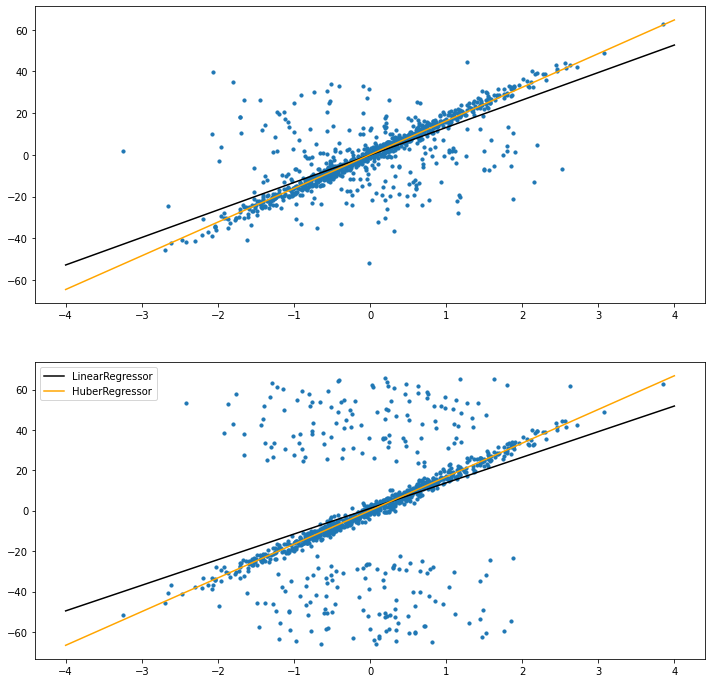

Score de la regresión lineal con un 25% de outliers : 0.5719756569862675
Score de la regresión de Huber con un 25% de outliers : 0.531718222446175
Score de la regresión lineal con un 25% de outliers pesados: 0.22561720874978042
Score de la regresión de Huber con un 25% de outliers pesados: 0.21402450350506452


In [118]:
from cProfile import label
from sklearn.linear_model import HuberRegressor

hr_outliers = HuberRegressor()
hr_exoutliers = HuberRegressor()

hr_outliers.fit((np.array(X_train_o2.feature_1).reshape(-1,1)), Y_train_o2)
hr_exoutliers.fit((np.array(X_train_eo2.feature_1).reshape(-1,1)), Y_train_eo2)

xspace = np.linspace(-4,4,1000)
yhat_outliers=hr_outliers.predict(xspace.reshape(1000,1))
yhat_exoutliers=hr_exoutliers.predict(xspace.reshape(1000,1))

fig, ax = plt.subplots(2)
fig.set_size_inches(12,12)

ax[0].scatter(df_o2.feature_1,df_o2.target,s=10)
ax[1].scatter(df_eo2.feature_1,df_eo2.target,s=10)

ax[0].plot(xspace,yhat_o2, color='black', label= "LinearRegressor")
ax[0].plot(xspace,yhat_outliers, color='orange', label= "HuberRegressor")

ax[1].plot(xspace,yhat_eo2, color='black', label= "LinearRegressor")
ax[1].plot(xspace,yhat_exoutliers, color='orange', label= "HuberRegressor")

plt.legend()
plt.show()

print(f"Score de la regresión lineal con un 25% de outliers : {lr_o2.score(np.array(df_o2.feature_1).reshape(-1,1),np.array(df_o2.target).reshape(-1,1))}")
print(f"Score de la regresión de Huber con un 25% de outliers : {hr_outliers.score(np.array(df_o2.feature_1).reshape(-1,1),np.array(df_o2.target).reshape(-1,1))}")
print(f"Score de la regresión lineal con un 25% de outliers pesados: {lr_eo2.score(np.array(df_eo2.feature_1).reshape(-1,1),np.array(df_eo2.target).reshape(-1,1))}")
print(f"Score de la regresión de Huber con un 25% de outliers pesados: {hr_outliers.score(np.array(df_eo2.feature_1).reshape(-1,1),np.array(df_eo2.target).reshape(-1,1))}")


Se puede comprobar que la regresión de Huber es más robusta que la lineal, siendo menos sensible a los outliers.

## Ejercicio 9 (Opcional)

Utilizando este esta funcion de Gradiente descendente de como idea, codear su implementación de Sthocastic Gradient Descent (SGD)

```python

def ssr_gradient(x, y, b):
    res = b[0] + b[1] * x - y
    return res.mean(), (res * x).mean()

def gradient_descent(
    x: list,
    y: list,
    start: list,
    learn_rate: float = 0.1,
    n_iter: int = 50,
    tolerance: float =1e-06
):
    vector = start
    for _ in range(n_iter):
        diff = -learn_rate * np.array(ssr_gradient(x, y, vector))
        if np.all(np.abs(diff) <= tolerance):
            break
        vector += diff
    return vector
```

# Tercera Parte

Vamos a crear un nuevo dataset, para ello vamos a usar el metodo `make_classification` de `sklearn`

In [125]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression

X, y = make_classification(
    n_samples = 1000,
    n_features=2,
    n_redundant=0,
    n_informative=2,
    random_state=1,
    n_classes=2,
    n_clusters_per_class=1
)

## Ejercicio 10

Con el dataset creado para clasficación vamos a utilizar el modelo `LogisticRegression`. Vamos a entrenar modelos variando los parámetros en particular `tol` y `max_iter`.
¿Cómo cambian estas regresiones?


In [220]:
import time

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7)


In [221]:
start = time.time()

clf1 = LogisticRegression(tol=0.0001, max_iter=100).fit(X_train,y_train)
clf1.predict(X_test[:10, :])

end = time.time()
print("tiempo de ejecución: {}".format(end - start))

tiempo de ejecución: 0.0029892921447753906


In [222]:
y_test[:10]

array([1, 1, 1, 1, 1, 0, 1, 0, 0, 0])

In [223]:
clf1.predict_proba(X_test[:10, :])

array([[7.32737075e-01, 2.67262925e-01],
       [9.75254903e-04, 9.99024745e-01],
       [1.05102497e-01, 8.94897503e-01],
       [3.50252714e-02, 9.64974729e-01],
       [3.31255776e-01, 6.68744224e-01],
       [9.62062581e-01, 3.79374187e-02],
       [3.96481810e-02, 9.60351819e-01],
       [9.95087911e-01, 4.91208853e-03],
       [3.35036726e-01, 6.64963274e-01],
       [8.58559720e-01, 1.41440280e-01]])

In [224]:
clf1.score(X_test, y_test)

0.87

In [225]:
start = time.time()

clf2 = LogisticRegression(tol=0.0001, max_iter=15).fit(X_train,y_train)
clf2.predict(X_test[:10, :])

end = time.time()
print("tiempo de ejecución: {}".format(end - start))

tiempo de ejecución: 0.0029997825622558594


In [226]:
y_test[:10]

array([1, 1, 1, 1, 1, 0, 1, 0, 0, 0])

In [227]:
clf2.score(X_test, y_test)

0.87

In [228]:
start = time.time()

clf3 = LogisticRegression(tol=0.0001, max_iter=500).fit(X_train,y_train)
clf3.predict(X_test[:10, :])

end = time.time()
print("tiempo de ejecución: {}".format(end - start))

tiempo de ejecución: 0.0019991397857666016


In [229]:
clf3.score(X_test, y_test)

0.87

Reduciendo considerablemente el número de máximo de iteraciones pero con tolerancia de error constante, el score se mantiene.

In [230]:
start = time.time()

clf4 = LogisticRegression(tol=0.005, max_iter=100).fit(X_train,y_train)
clf4.predict(X_test[:10, :])

end = time.time()
print("tiempo de ejecución: {}".format(end - start))
print(f"score:{clf4.score(X_test, y_test)}")

tiempo de ejecución: 0.0019989013671875
score:0.87


In [231]:
start = time.time()

clf5 = LogisticRegression(tol=0.05, max_iter=100).fit(X_train,y_train)
clf5.predict(X_test[:10, :])

end = time.time()
print("tiempo de ejecución: {}".format(end - start))
print(f"score:{clf4.score(X_test, y_test)}")

tiempo de ejecución: 0.0019998550415039062
score:0.87


In [232]:
start = time.time()

clf5 = LogisticRegression(tol=0.1, max_iter=100).fit(X_train,y_train)
clf5.predict(X_test[:10, :])

end = time.time()
print("tiempo de ejecución: {}".format(end - start))
print(f"score:{clf4.score(X_test, y_test)}")

tiempo de ejecución: 0.002997875213623047
score:0.87


In [233]:
start = time.time()

clf5 = LogisticRegression(tol=0.000001, max_iter=1000).fit(X_train,y_train)
clf5.predict(X_test[:10, :])

end = time.time()
print("tiempo de ejecución: {}".format(end - start))
print(f"score:{clf4.score(X_test, y_test)}")

tiempo de ejecución: 0.002000093460083008
score:0.87


In [234]:
start = time.time()

clf6 = LogisticRegression(tol=0.11, max_iter=10).fit(X_train,y_train)
clf6.predict(X_test[:10, :])

end = time.time()
print("tiempo de ejecución: {}".format(end - start))
print(f"score:{clf4.score(X_test, y_test)}")

tiempo de ejecución: 0.0019991397857666016
score:0.87


## Ejercicio 11

Vamos a utilizar ahora el dataset de [iris](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_iris.html). Utilizando `LogisticRegression` vamos a realizar un clasificador multiclases.
¿Cómo se compara con el modelo de `Perceptron`?

In [236]:
from sklearn.datasets import load_iris
X,y = load_iris(return_X_y=True, as_frame=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7)


HINT: La clase perceptron la pueden utilizar así

```python
from sklearn.linear_model import Perceptron
X, y = load_iris(return_X_y=True, as_frame=True)
clf = Perceptron(tol=1e-3, random_state=0)
clf.fit(X, y)

clf.score(X, y)
```

In [239]:
logclf = LogisticRegression().fit(X_train, y_train)
logclf.predict(X_test)
logclf.score(X_test,y_test)

0.9555555555555556

In [243]:
from sklearn.linear_model import Perceptron

perclf = Perceptron(tol=0.000001)
perclf.fit(X_train, y_train)
perclf.score(X_test, y_test)

0.6666666666666666

El modelo del regresor logístico muestra un mejor resultado para esta clasificación.